In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import chi2_contingency

# load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [2]:
# preview of the dataset 
print(train_df.info(5))
print(test_df.info(5))
print(train_df.head(5))
print(test_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

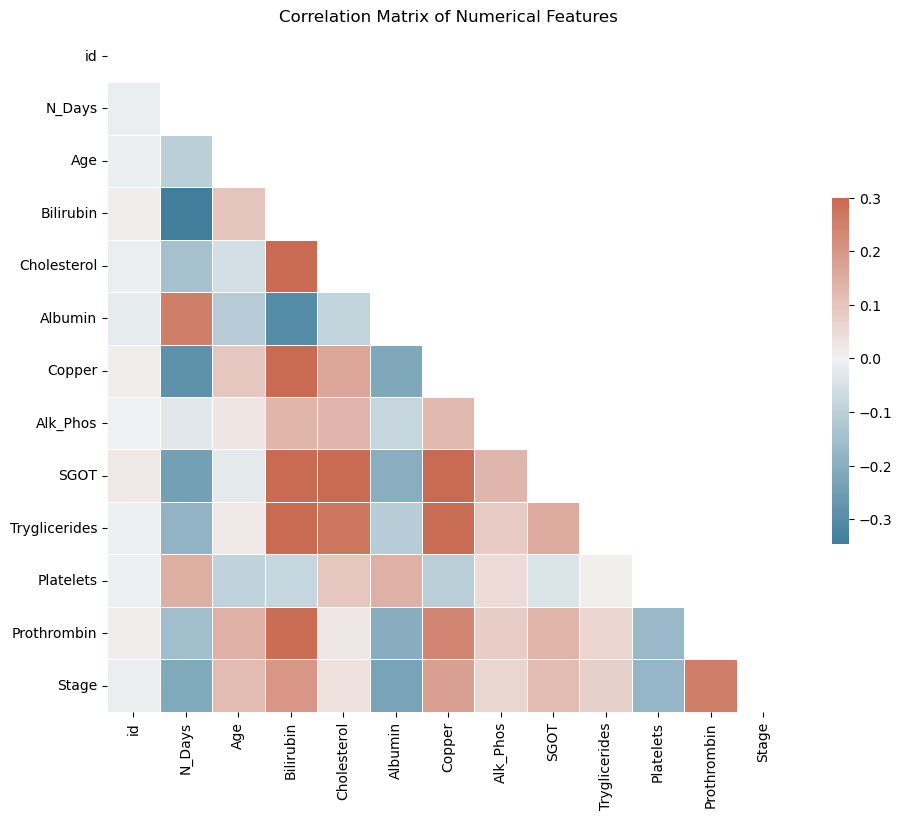

In [3]:
# Correlation matrix for numerical columns
corr = train_df.select_dtypes(include=['float64', 'int64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(230, 20, as_cmap=True),
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The range of correlation isn't anywhere close to perfect

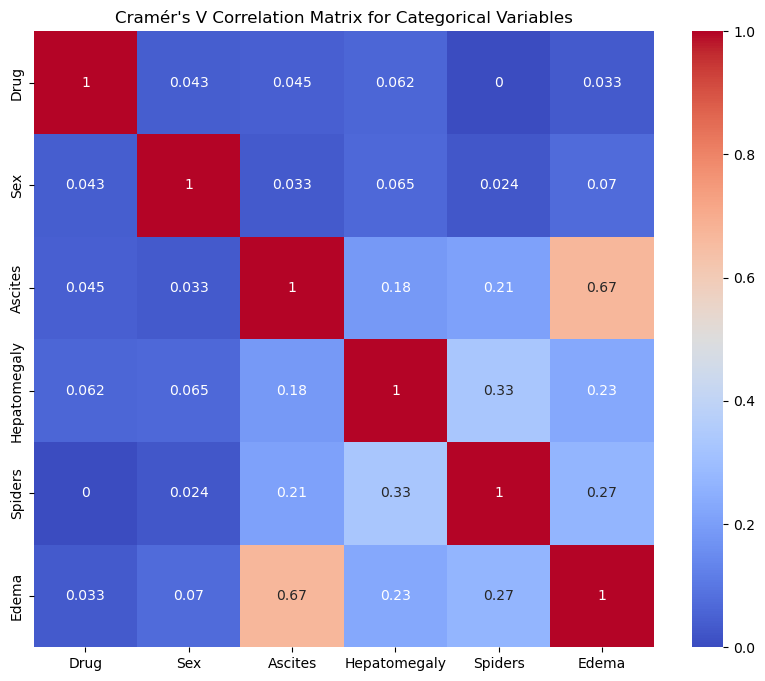

In [4]:
#Cramers V chi square test to compare categorical variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Categorical variables
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Calculating Cramér's V matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features), len(categorical_features))), index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        cramers_v_matrix.loc[col1, col2] = cramers_v(train_df[col1], train_df[col2])

# Plotting the Cramér's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title("Cramér's V Correlation Matrix for Categorical Variables")
plt.show()

Ascites and Edema seem to have the strongest relationship (perhaps too much correlation)

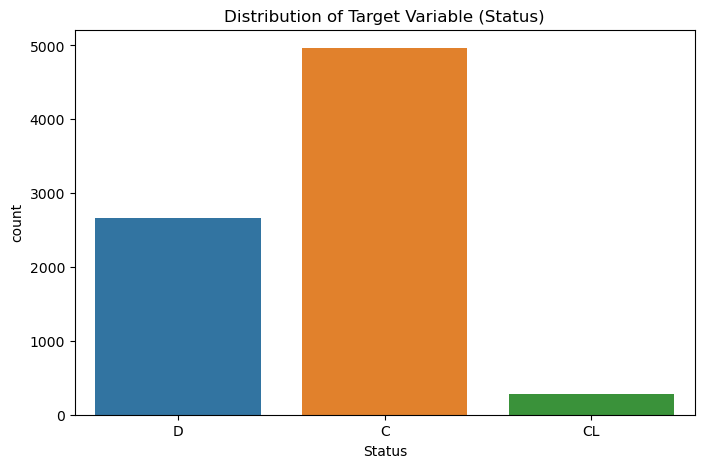

In [5]:
# Count plot for the target variable 'Status'
plt.figure(figsize=(8, 5))
sns.countplot(x='Status', data=train_df)
plt.title('Distribution of Target Variable (Status)')
plt.show()

Status has an EXTREMELY imbalanced distribution (~63% for C, ~34% D, ~3.5% for CL)

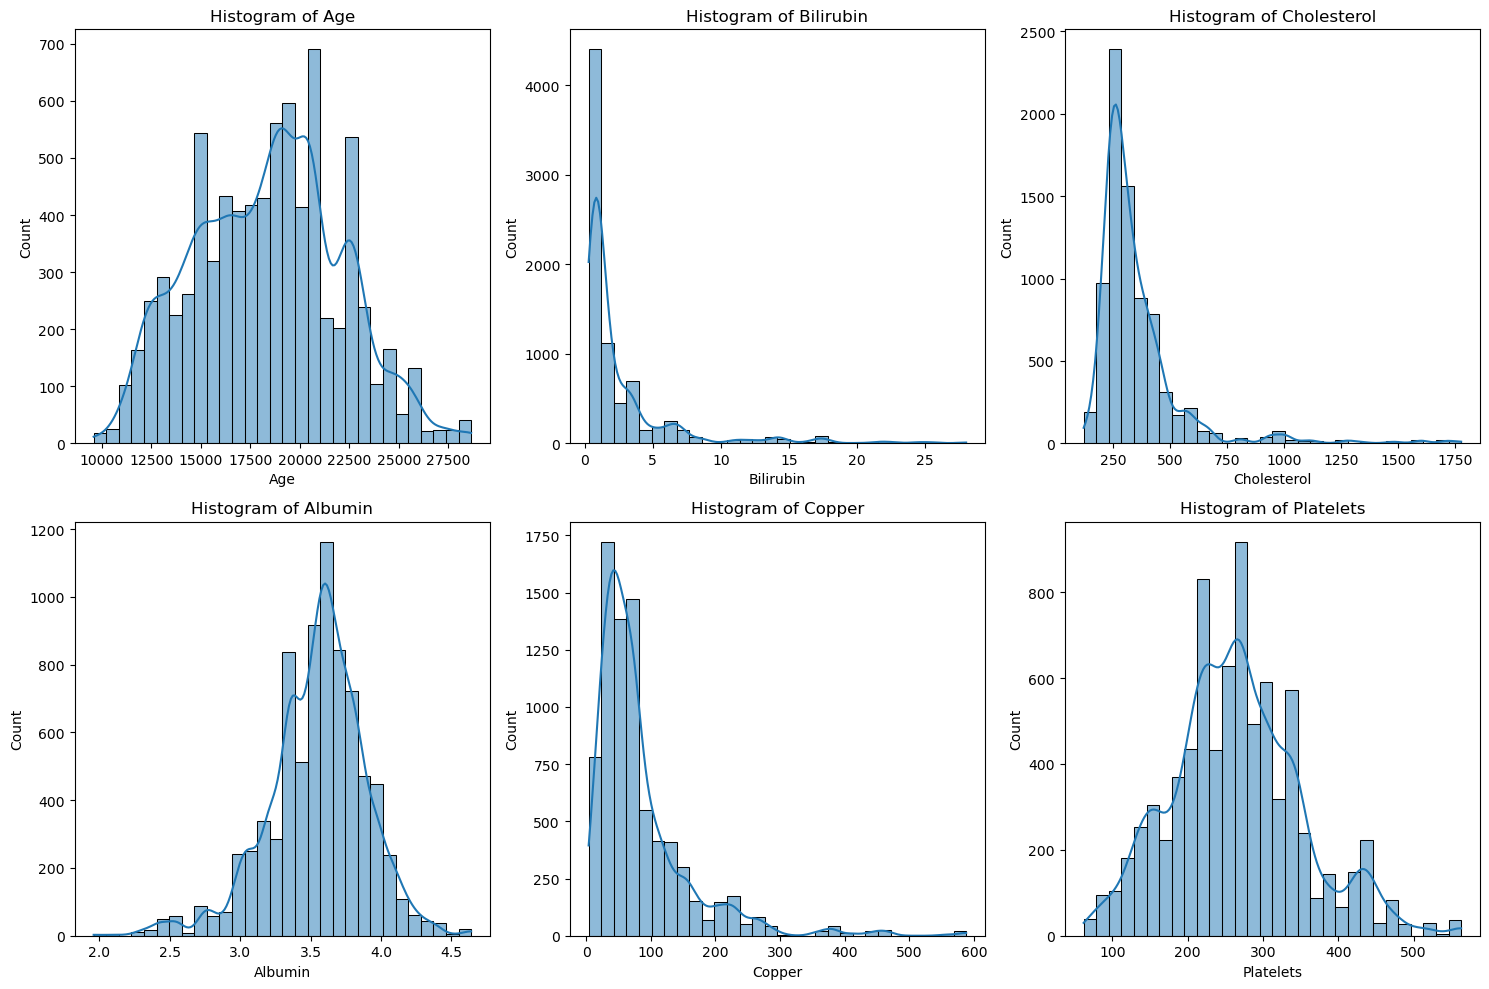

In [6]:
# Histograms for selected numerical features
features_to_plot = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Platelets']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

Bilirubin, Copper, and Cholesterol is skewed right.  Platelets, Albumin, and Age are mostly normally distributed, however Albumin has a gap right below the mean, Platelets has a couple large gaps, and Age has a noticeable gap at ~21000 (57.5 years old).

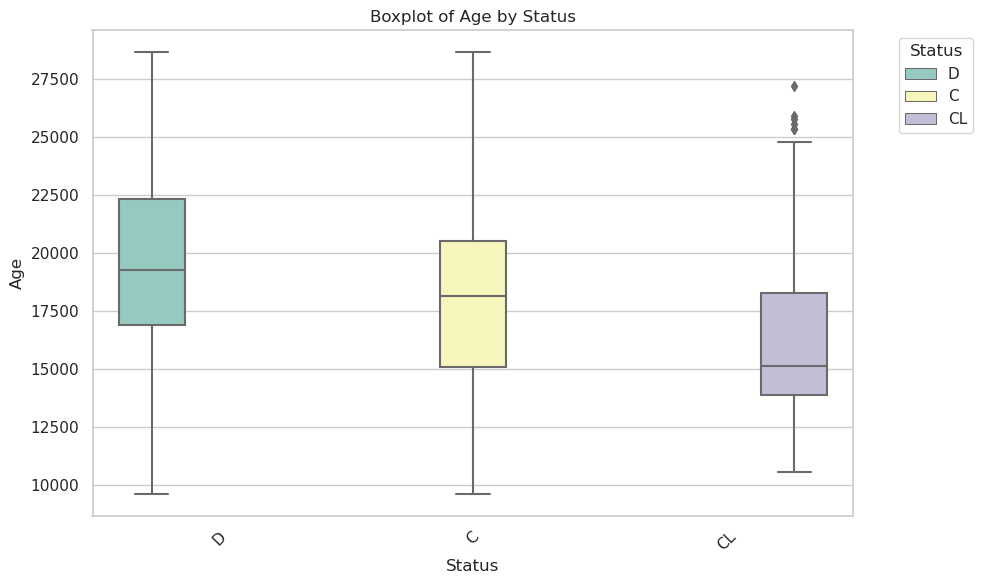

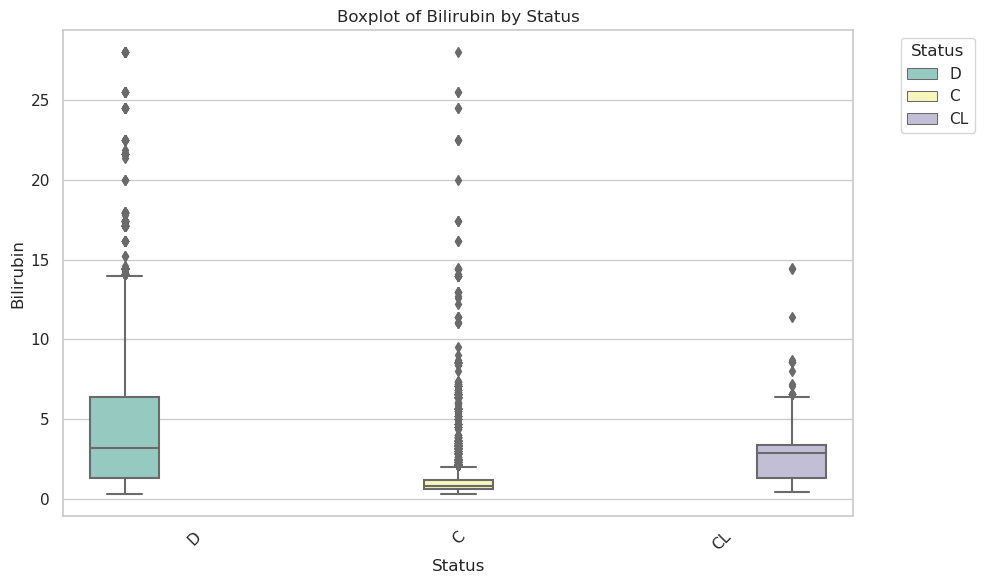

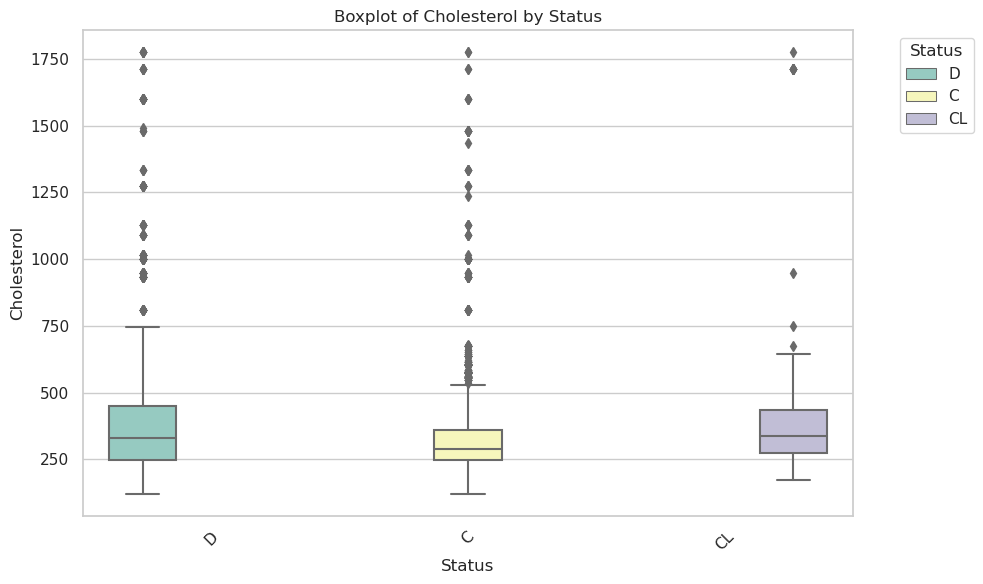

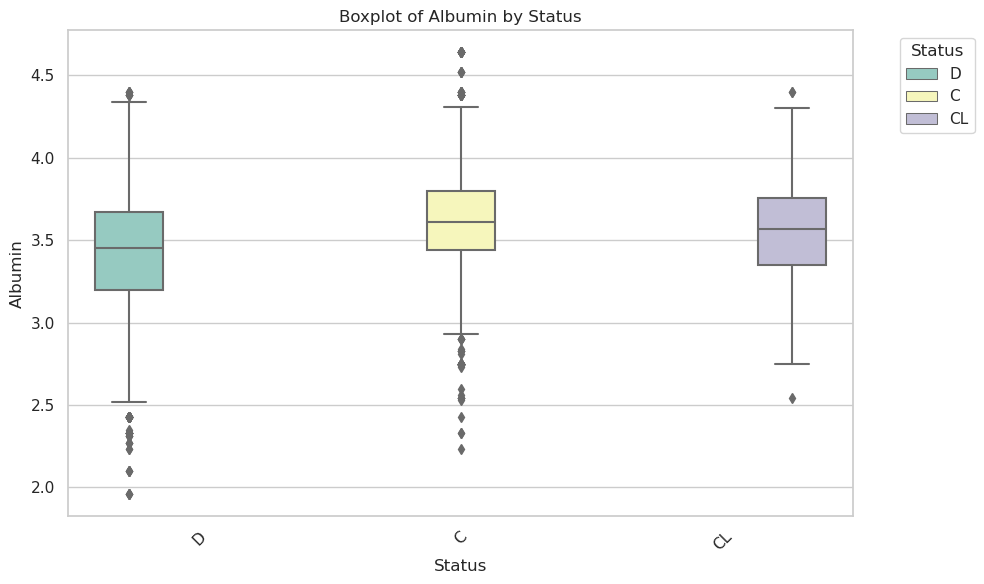

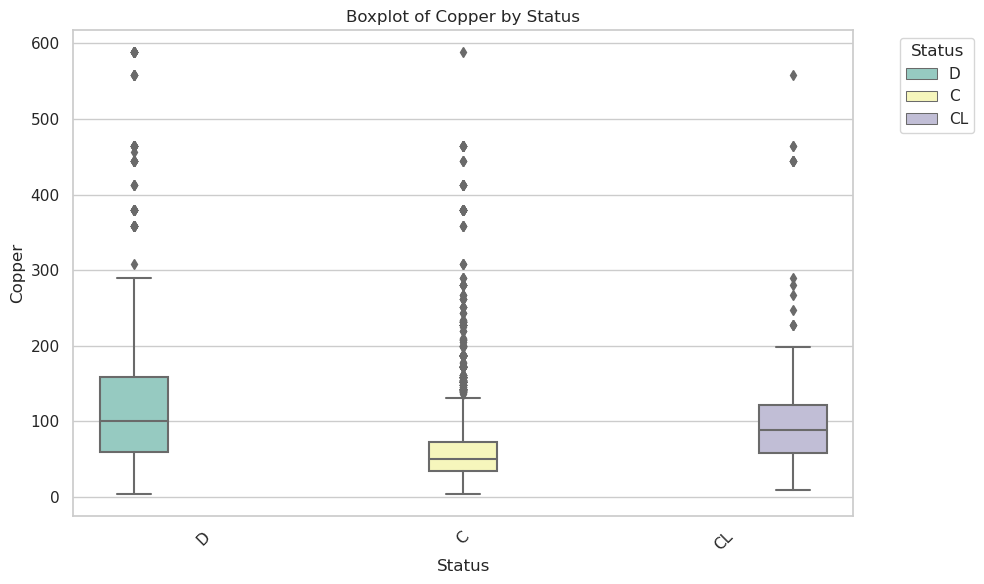

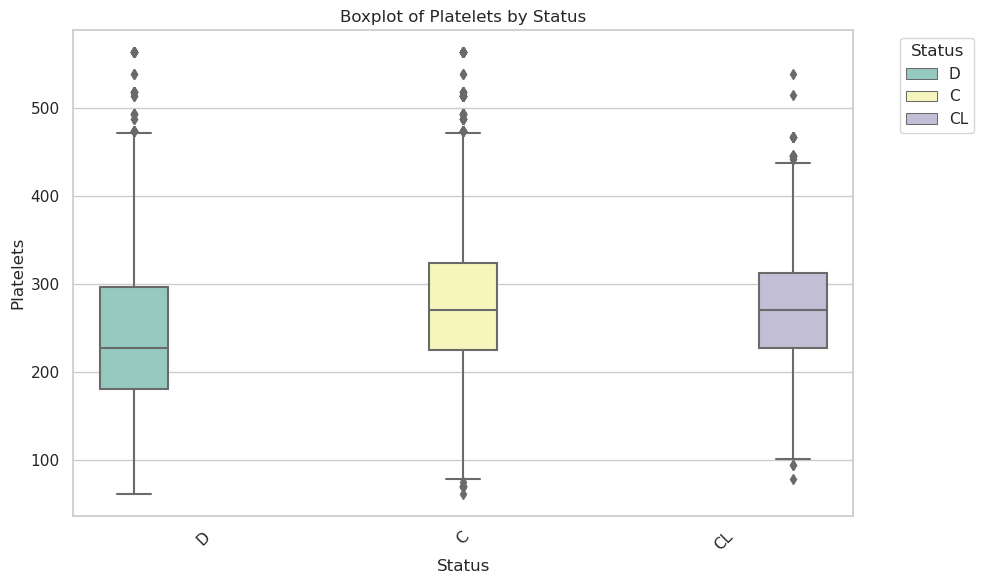

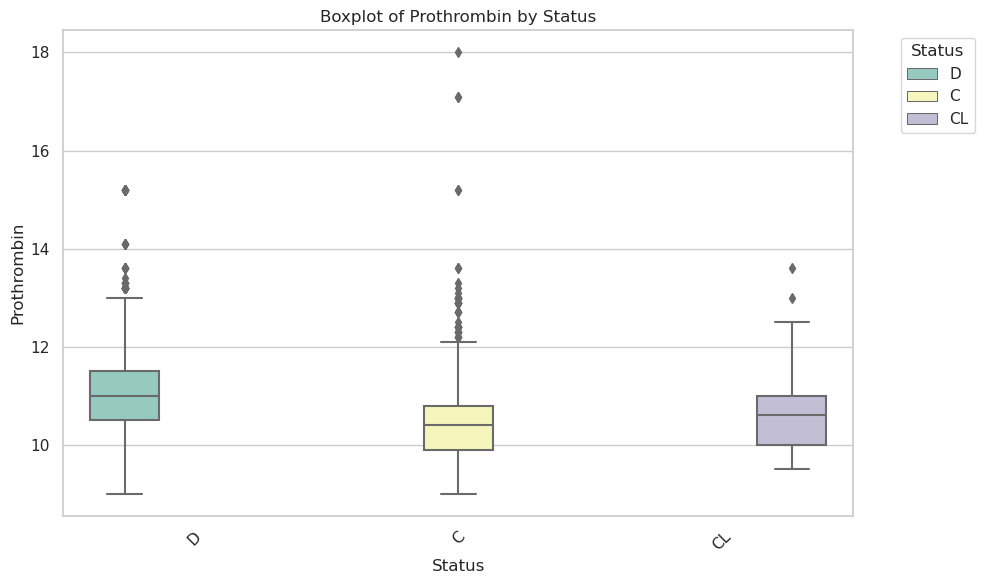

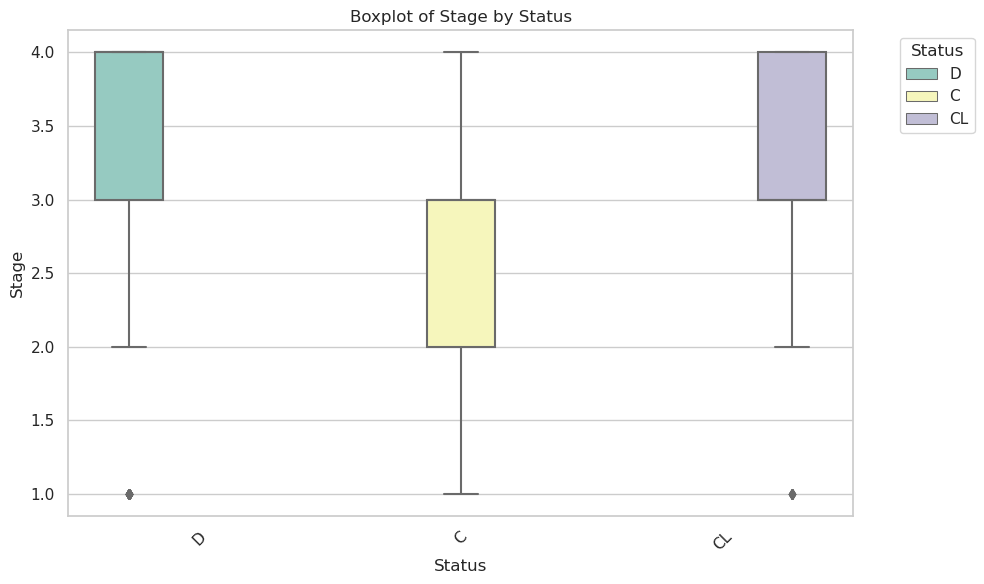

In [10]:
#boxplots shows spread, if there are a lot of outliers, status effect on them, ect
# List of numerical features 
numerical_features = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Platelets', 'Prothrombin', 'Stage']

# Setting the aesthetic 
sns.set(style="whitegrid")

# Creating box plots for each numerical feature against the target variable 'Status'
for col in numerical_features:
    plt.figure(figsize=(10, 6))  # Adjusting the figure size for better readability
    sns.boxplot(x='Status', y=col, hue="Status", data=train_df, palette="Set3")
    plt.title(f'Boxplot of {col} by Status')
    plt.xlabel('Status')  # Customizing the x-axis label
    plt.ylabel(col)  # Customizing the y-axis label
    plt.xticks(rotation=45)  # Rotate the x-axis labels 
    plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjusting legend position so it is not overlapping
    plt.tight_layout()  
    plt.show()


CL and C tend to have the most outliers.

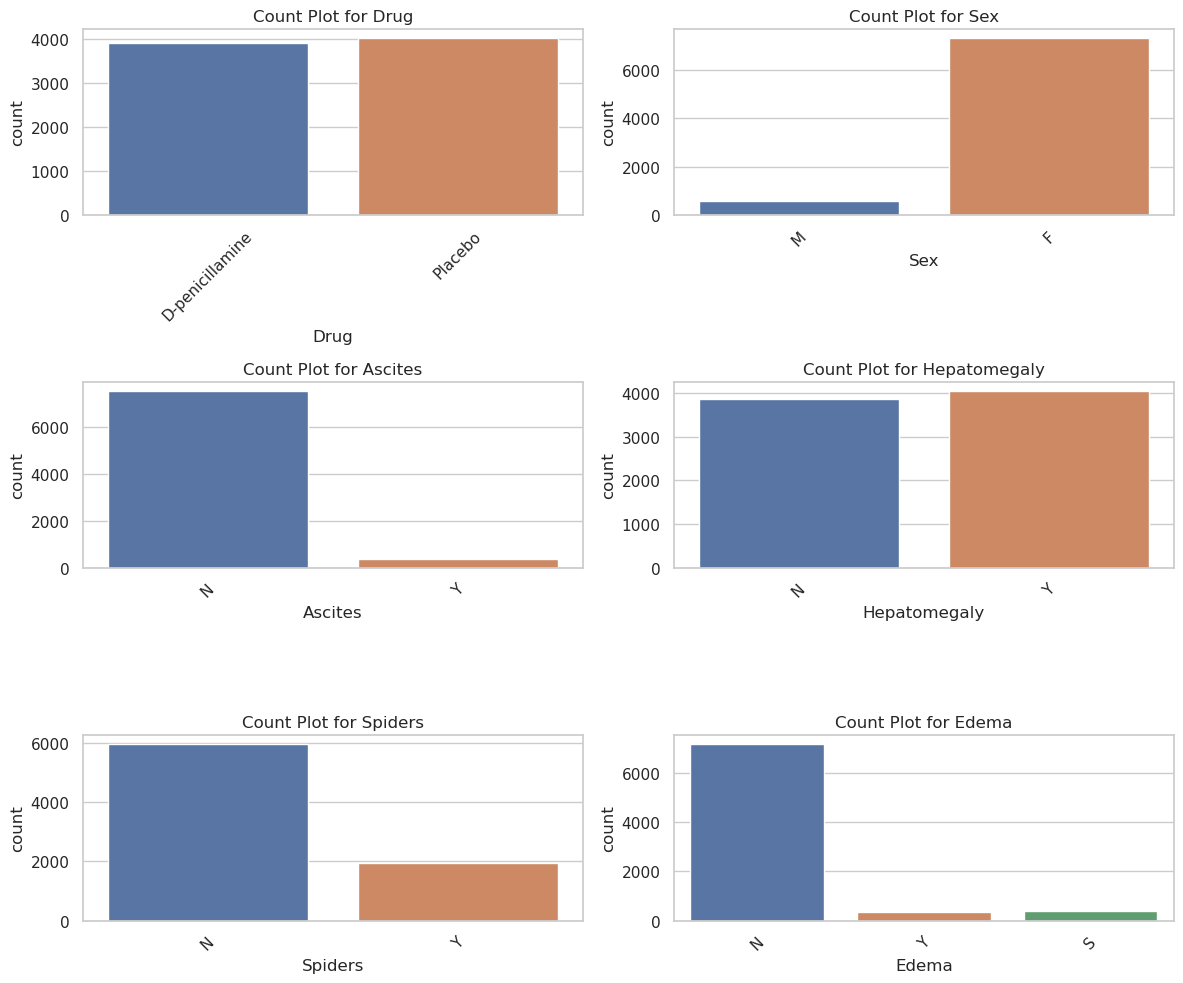

In [11]:
# Categorical variables 
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Setting the overall aesthetics for seaborn
sns.set(style="whitegrid")

# Creating count plots for each categorical variable
plt.figure(figsize=(12, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)  
    sns.countplot(x=feature, data=train_df)
    plt.title(f'Count Plot for {feature}')
    plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

Once again, you can see the imbalance of the data when showing the count of different categories.

In [8]:
# One-Hot Encoding categorical variables 
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_features = one_hot_encoder.fit_transform(train_df[categorical_features])
encoded_features_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names(categorical_features))
train_df_encoded = pd.concat([train_df.drop(categorical_features, axis=1), encoded_features_df], axis=1)

# Standardizing numerical features 
numerical_features = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Platelets', 'Prothrombin', 'Stage']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_df[numerical_features])
scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_features)
train_df_standardized = pd.concat([train_df.drop(numerical_features, axis=1), scaled_features_df], axis=1)

# Output the first few rows of the processed dataset 
print(train_df_encoded.head())
print(train_df_standardized.head())

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'